In [65]:
from kerastuner.tuners import RandomSearch, Hyperband, BayesianOptimization
from matplotlib import pyplot as plt
from functools import partial
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Concatenate, Lambda
from tensorflow.keras import regularizers
import pandas as pd
import numpy as np
import tensorflow as tf
import random
import cv2
import os
import keras

In [66]:
df_X = pd.read_csv('dataset/train_features.csv')
df_y = pd.read_csv('dataset/train_target.csv')

In [67]:
df_X

,id,Time,S1,S2,S3,S4
0,0,0.000000,0.00,0.0,0.00,0.00
1,0,0.000004,0.00,0.0,0.00,0.00
2,0,0.000008,0.00,0.0,0.00,0.00
3,0,0.000012,0.00,0.0,0.00,0.00
4,0,0.000016,0.00,0.0,0.00,0.00
...,...,...,...,...,...,...
1049995,2799,0.001480,-89256.32,-164614.6,48186.29,-147910.20
1049996,2799,0.001484,-29233.44,-179404.2,109534.40,-111591.10
1049997,2799,0.001488,37147.25,-190011.7,178781.10,-86836.78
1049998,2799,0.001492,98278.50,-190771.4,245726.70,-75660.00


In [68]:
df_y

,id,X,Y,M,V
0,0,0.0,-400.0,50.0,0.4
1,1,400.0,0.0,100.0,1.0
2,2,-300.0,-200.0,25.0,0.4
3,3,200.0,-100.0,150.0,0.4
4,4,-300.0,-100.0,150.0,0.4
...,...,...,...,...,...
2795,2795,200.0,200.0,50.0,1.0
2796,2796,-400.0,-400.0,150.0,0.2
2797,2797,-100.0,0.0,50.0,0.2
2798,2798,100.0,100.0,125.0,0.6


In [69]:
for col in df_X.columns:
    print(f'{col}: {df_X[col].isnull().values.any()}')
for col in df_y.columns:
    print(f'{col}: {df_y[col].isnull().values.any()}')

id: False
Time: False
S1: False
S2: False
S3: False
S4: False
id: False
X: False
Y: False
M: False
V: False


In [70]:
def data_processing(data_frame,feature_list,conc_list=list()):
    for feature in feature_list:
        conc_list.append(np.asarray(data_frame[feature]).reshape(-1,375,1))
    conc_array = np.concatenate(conc_list,axis=2)
    array = conc_array.transpose(0,2,1)
    return array

(2800, 4, 375)


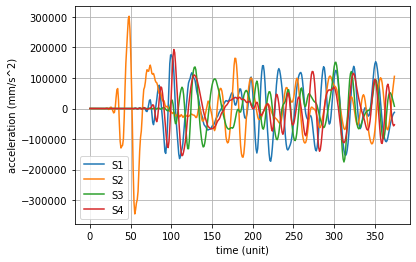

In [71]:
data = data_processing(df_X,['S1','S2','S3','S4'])

plt.figure(figsize=(6,4))
plt.plot(data[777].T)
plt.legend(['S1','S2','S3','S4'])
plt.grid(True)
plt.xlabel('time (unit)')
plt.ylabel('acceleration (mm/s^2)')

x = data
print(x.shape)

In [72]:
try_data = x[0]
N = 375 # Sample number
f = np.linspace(0,N-1,N) # Frequency step
instance_list = list()
for instance in try_data:
    y = np.array(instance).astype(np.float)
    mean = np.mean(y)
    X = np.fft.fft(y-mean)
    X_mag = np.abs(X)
    f_plot = f[0:int(N/2)]
    X_mag_plot = 2*X_mag[0:int(N/2)]
    X_mag_plot[0] /= 2
    instance_list.append(X_mag_plot)

In [73]:
fft_data_list = list()
for data_instance in data:
    N = 375 # Sample number
    f = np.linspace(0,N-1,N) # Frequency step
    instance_list = list()
    for instance in try_data:
        y = np.array(instance).astype(np.float)
        mean = np.mean(y)
        X = np.fft.fft(y-mean)
        X_mag = np.abs(X)
        f_plot = f[0:int(N/2)]
        X_mag_plot = 2*X_mag[0:int(N/2)]
        X_mag_plot[0] /= 2
        instance_list.append(X_mag_plot)
    fft_data_list.append(instance_list)

In [74]:
y = df_y.drop(['id','M','V'],axis=1)
y_numpy = y.to_numpy()
y_list = y_numpy.tolist()

In [75]:
# raw waveform data
x_array = data
y_array = y_list
train_test_index = int(len(x_array)*0.9)
zip_list = list(zip(x_array,y_array))
random.shuffle(zip_list)
x_array,y_array = zip(*zip_list)
x_train,y_train = np.array(x_array[0:train_test_index]),np.array(y_array[0:train_test_index])
x_test,y_test = np.array(x_array[train_test_index:]),np.array(y_array[train_test_index:])

In [76]:
# fast fourier transform data
x_array_fft = fft_data_list
y_array_fft = y_list
train_test_index_fft = int(len(x_array_fft)*0.9)
zip_list_fft = list(zip(x_array_fft,y_array_fft))
random.shuffle(zip_list_fft)
x_array_fft,y_array_fft = zip(*zip_list_fft)
x_train_fft,y_train_fft = np.array(x_array_fft[0:train_test_index_fft]),np.array(y_array_fft[0:train_test_index_fft])
x_test_fft,y_test_fft = np.array(x_array_fft[train_test_index_fft:]),np.array(y_array_fft[train_test_index_fft:])

In [77]:
patch_number = 4

# raw waveform data
for patch in range(patch_number):
    vars()[f'train_list{patch+1}'] = list()
    vars()[f'test_list{patch+1}'] = list()

for ele in x_train:
    train_list1.append(ele[0])
    train_list2.append(ele[1])
    train_list3.append(ele[2])
    train_list4.append(ele[3])

for ele in x_test:
    test_list1.append(ele[0])
    test_list2.append(ele[0])
    test_list3.append(ele[0])
    test_list4.append(ele[0])
    
# fast fourier transform
for patch in range(patch_number):
    vars()[f'train_list_fft{patch+1}'] = list()
    vars()[f'test_list_fft{patch+1}'] = list()

for ele in x_train_fft:
    train_list_fft1.append(ele[0])
    train_list_fft2.append(ele[1])
    train_list_fft3.append(ele[2])
    train_list_fft4.append(ele[3])

for ele in x_test_fft:
    test_list_fft1.append(ele[0])
    test_list_fft2.append(ele[1])
    test_list_fft3.append(ele[2])
    test_list_fft4.append(ele[3])

# for Global training and testing
train_fit = list()
train_fft_fit = list()
test_fit = list()
test_fft_fit = list()

for i in range(4):
    vars()[f'train_list{i+1}'] = np.array(vars()[f'train_list{i+1}'])
    train_fit.append(vars()[f'train_list{i+1}'])
    vars()[f'train_list_fft{i+1}'] = np.array(vars()[f'train_list_fft{i+1}'])
    train_fft_fit.append(vars()[f'train_list_fft{i+1}'])
    vars()[f'test_list{i+1}'] = np.array(vars()[f'test_list{i+1}'])
    test_fit.append(vars()[f'test_list{i+1}'])
    vars()[f'test_list_fft{i+1}'] = np.array(vars()[f'test_list_fft{i+1}'])
    test_fft_fit.append(vars()[f'test_list_fft{i+1}'])
    

# for PatchNet training
train_list1 = np.expand_dims(train_list1,axis=2)
train_list2 = np.expand_dims(train_list2,axis=2)
train_list3 = np.expand_dims(train_list3,axis=2)
train_list4 = np.expand_dims(train_list4,axis=2)

train_list_fft1 = np.expand_dims(train_list_fft1,axis=2)
train_list_fft2 = np.expand_dims(train_list_fft2,axis=2)
train_list_fft3 = np.expand_dims(train_list_fft3,axis=2)
train_list_fft4 = np.expand_dims(train_list_fft4,axis=2)

In [78]:
len(test_fit)

4

In [79]:
def PatchNet_HP(hp):
    scaler = hp.Int('scaler',min_value=5,max_value=10,step=1)
    defaultConv1D = partial(tf.keras.layers.Conv1D,kernel_size=3,
                                                   kernel_initializer=tf.keras.initializers.lecun_normal)
    momentums=hp.Choice('momentum',[0.9,0.99,0.999])
    learning_rate = hp.Choice('learning_rate',[0.1,0.01,0.001])
    
    model = tf.keras.Sequential()
    model.add(defaultConv1D(filters=2*scaler))
    model.add(tf.keras.layers.BatchNormalization(momentum=momentums))
    model.add(tf.keras.layers.Activation('selu'))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
    model.add(defaultConv1D(filters=3*scaler))
    model.add(tf.keras.layers.BatchNormalization(momentum=momentums))
    model.add(tf.keras.layers.Activation('selu'))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
    model.add(defaultConv1D(filters=4*scaler))
    model.add(tf.keras.layers.BatchNormalization(momentum=momentums))
    model.add(tf.keras.layers.Activation('selu'))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
    model.add(defaultConv1D(filters=5*scaler))
    model.add(tf.keras.layers.BatchNormalization(momentum=momentums))
    model.add(tf.keras.layers.Activation('selu'))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(units=50,kernel_initializer=tf.keras.initializers.lecun_normal))
    model.add(tf.keras.layers.BatchNormalization(momentum=momentums))
    model.add(tf.keras.layers.Activation('selu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(units=4))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='mean_absolute_error',
                  metrics=['mean_absolute_error'])
    return model

In [55]:
tuner1 = BayesianOptimization(PatchNet_HP,
                              objective='val_mean_absolute_error',
                              max_trials=20,
                              directory='D:/Users/Admin/Desktop/raw/weights')

In [56]:
tuner1.search_space_summary()

Search space summary
Default search space size: 3
scaler (Int)
{'default': None, 'conditions': [], 'min_value': 5, 'max_value': 10, 'step': 1, 'sampling': None}
momentum (Choice)
{'default': 0.9, 'conditions': [], 'values': [0.9, 0.99, 0.999], 'ordered': True}
learning_rate (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.01, 0.001], 'ordered': True}


In [57]:
train_list1 = np.expand_dims(train_list1,axis=2)
tuner1.search(train_list1,y_train,batch_size=16,epochs=20,validation_split=0.2)

Trial 20 Complete [00h 00m 30s]
val_mean_absolute_error: 29.02998924255371

Best val_mean_absolute_error So Far: 25.888648986816406
Total elapsed time: 00h 11m 07s
INFO:tensorflow:Oracle triggered exit


In [58]:
tuner1.results_summary()

Results summary
Results in D:/Users/Admin/Desktop/raw/weights\untitled_project
Showing 10 best trials
Objective(name='val_mean_absolute_error', direction='min')
Trial summary
Hyperparameters:
scaler: 9
momentum: 0.99
learning_rate: 0.01
Score: 25.888648986816406
Trial summary
Hyperparameters:
scaler: 9
momentum: 0.99
learning_rate: 0.01
Score: 26.25681495666504
Trial summary
Hyperparameters:
scaler: 9
momentum: 0.9
learning_rate: 0.01
Score: 26.558427810668945
Trial summary
Hyperparameters:
scaler: 8
momentum: 0.9
learning_rate: 0.1
Score: 29.02998924255371
Trial summary
Hyperparameters:
scaler: 10
momentum: 0.99
learning_rate: 0.1
Score: 29.111597061157227
Trial summary
Hyperparameters:
scaler: 7
momentum: 0.99
learning_rate: 0.001
Score: 36.369606018066406
Trial summary
Hyperparameters:
scaler: 7
momentum: 0.99
learning_rate: 0.001
Score: 37.15489196777344
Trial summary
Hyperparameters:
scaler: 9
momentum: 0.9
learning_rate: 0.001
Score: 37.57899475097656
Trial summary
Hyperparameter

# PatchNet Training

In [80]:
from keras import callbacks
early_stopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 50, 
                                        restore_best_weights = True)

## Model 1

In [81]:
defaultConv1D = partial(tf.keras.layers.Conv1D,kernel_size=3,
                                               kernel_initializer=tf.keras.initializers.lecun_normal)
scaler = 9
momentum = 0.99
learning_rate = 0.001

model1 = tf.keras.Sequential()
model1.add(defaultConv1D(filters=2*scaler))
model1.add(tf.keras.layers.BatchNormalization(momentum=momentum))
model1.add(tf.keras.layers.Activation('selu'))
model1.add(tf.keras.layers.MaxPooling1D(pool_size=2))
model1.add(defaultConv1D(filters=3*scaler))
model1.add(tf.keras.layers.BatchNormalization(momentum=momentum))
model1.add(tf.keras.layers.Activation('selu'))
model1.add(tf.keras.layers.MaxPooling1D(pool_size=2))
model1.add(defaultConv1D(filters=4*scaler))
model1.add(tf.keras.layers.BatchNormalization(momentum=momentum))
model1.add(tf.keras.layers.Activation('selu'))
model1.add(tf.keras.layers.MaxPooling1D(pool_size=2))
model1.add(defaultConv1D(filters=5*scaler))
model1.add(tf.keras.layers.BatchNormalization(momentum=momentum))
model1.add(tf.keras.layers.Activation('selu'))
model1.add(tf.keras.layers.MaxPooling1D(pool_size=2))
model1.add(tf.keras.layers.Flatten())
model1.add(tf.keras.layers.Dense(units=50,kernel_initializer=tf.keras.initializers.lecun_normal))
model1.add(tf.keras.layers.BatchNormalization(momentum=momentum))
model1.add(tf.keras.layers.Activation('selu'))
model1.add(tf.keras.layers.Dropout(0.5))
model1.add(tf.keras.layers.Dense(units=2))

model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss='mean_absolute_error',
              metrics=['mean_absolute_error'])

In [82]:
history1 = model1.fit(train_list1,y_train,batch_size=32,epochs=600,
                      validation_split=0.2,callbacks=[early_stopping])

Epoch 1/600
63/63 [==============================] - 9s 56ms/step - loss: 220.9021 - mean_absolute_error: 220.9021 - val_loss: 214.9333 - val_mean_absolute_error: 214.9333
Epoch 2/600
63/63 [==============================] - 1s 19ms/step - loss: 216.3257 - mean_absolute_error: 216.3257 - val_loss: 212.1569 - val_mean_absolute_error: 212.1569
Epoch 3/600
63/63 [==============================] - 1s 19ms/step - loss: 212.9876 - mean_absolute_error: 212.9876 - val_loss: 209.6666 - val_mean_absolute_error: 209.6666
Epoch 4/600
63/63 [==============================] - 1s 19ms/step - loss: 210.5022 - mean_absolute_error: 210.5022 - val_loss: 206.7457 - val_mean_absolute_error: 206.7457
Epoch 5/600
63/63 [==============================] - 1s 20ms/step - loss: 206.8837 - mean_absolute_error: 206.8837 - val_loss: 203.3120 - val_mean_absolute_error: 203.3120
Epoch 6/600
63/63 [==============================] - 1s 21ms/step - loss: 204.1835 - mean_absolute_error: 204.1835 - val_loss: 200.6293 - va

Epoch 49/600
63/63 [==============================] - 1s 19ms/step - loss: 66.7160 - mean_absolute_error: 66.7160 - val_loss: 43.3684 - val_mean_absolute_error: 43.3684
Epoch 50/600
63/63 [==============================] - 1s 18ms/step - loss: 65.3061 - mean_absolute_error: 65.3061 - val_loss: 43.8503 - val_mean_absolute_error: 43.8503
Epoch 51/600
63/63 [==============================] - 1s 19ms/step - loss: 66.1557 - mean_absolute_error: 66.1557 - val_loss: 42.3077 - val_mean_absolute_error: 42.3077
Epoch 52/600
63/63 [==============================] - 1s 19ms/step - loss: 65.2412 - mean_absolute_error: 65.2412 - val_loss: 41.8583 - val_mean_absolute_error: 41.8583
Epoch 53/600
63/63 [==============================] - 1s 20ms/step - loss: 66.0777 - mean_absolute_error: 66.0777 - val_loss: 44.1579 - val_mean_absolute_error: 44.1579
Epoch 54/600
63/63 [==============================] - 1s 19ms/step - loss: 64.2704 - mean_absolute_error: 64.2704 - val_loss: 45.2058 - val_mean_absolute_e

Epoch 97/600
63/63 [==============================] - 2s 32ms/step - loss: 62.2722 - mean_absolute_error: 62.2722 - val_loss: 35.3149 - val_mean_absolute_error: 35.3149
Epoch 98/600
63/63 [==============================] - 2s 31ms/step - loss: 66.1076 - mean_absolute_error: 66.1076 - val_loss: 36.7210 - val_mean_absolute_error: 36.7210
Epoch 99/600
63/63 [==============================] - 2s 31ms/step - loss: 62.8231 - mean_absolute_error: 62.8231 - val_loss: 34.4257 - val_mean_absolute_error: 34.4257
Epoch 100/600
63/63 [==============================] - 2s 32ms/step - loss: 66.3655 - mean_absolute_error: 66.3655 - val_loss: 34.2912 - val_mean_absolute_error: 34.2912
Epoch 101/600
63/63 [==============================] - 2s 32ms/step - loss: 61.5234 - mean_absolute_error: 61.5234 - val_loss: 33.5589 - val_mean_absolute_error: 33.5589
Epoch 102/600
63/63 [==============================] - 2s 37ms/step - loss: 59.9508 - mean_absolute_error: 59.9508 - val_loss: 39.1579 - val_mean_absolut

63/63 [==============================] - 2s 33ms/step - loss: 59.1349 - mean_absolute_error: 59.1349 - val_loss: 35.1852 - val_mean_absolute_error: 35.1852
Epoch 146/600
63/63 [==============================] - 2s 33ms/step - loss: 62.6551 - mean_absolute_error: 62.6551 - val_loss: 32.3780 - val_mean_absolute_error: 32.3780
Epoch 147/600
63/63 [==============================] - 2s 33ms/step - loss: 63.5181 - mean_absolute_error: 63.5181 - val_loss: 34.0045 - val_mean_absolute_error: 34.0045
Epoch 148/600
63/63 [==============================] - 2s 35ms/step - loss: 61.1568 - mean_absolute_error: 61.1568 - val_loss: 31.4428 - val_mean_absolute_error: 31.4428
Epoch 149/600
63/63 [==============================] - 2s 31ms/step - loss: 57.6510 - mean_absolute_error: 57.6510 - val_loss: 31.2483 - val_mean_absolute_error: 31.2483
Epoch 150/600
63/63 [==============================] - 2s 33ms/step - loss: 58.3222 - mean_absolute_error: 58.3222 - val_loss: 35.7677 - val_mean_absolute_error: 35

63/63 [==============================] - 2s 35ms/step - loss: 59.8955 - mean_absolute_error: 59.8955 - val_loss: 31.7077 - val_mean_absolute_error: 31.7077
Epoch 194/600
63/63 [==============================] - 2s 32ms/step - loss: 58.8692 - mean_absolute_error: 58.8692 - val_loss: 32.4990 - val_mean_absolute_error: 32.4990
Epoch 195/600
63/63 [==============================] - 2s 32ms/step - loss: 57.1959 - mean_absolute_error: 57.1959 - val_loss: 30.3377 - val_mean_absolute_error: 30.3377
Epoch 196/600
63/63 [==============================] - 2s 31ms/step - loss: 62.5794 - mean_absolute_error: 62.5794 - val_loss: 32.1349 - val_mean_absolute_error: 32.1349
Epoch 197/600
63/63 [==============================] - 2s 31ms/step - loss: 57.4612 - mean_absolute_error: 57.4612 - val_loss: 29.9958 - val_mean_absolute_error: 29.9958
Epoch 198/600
63/63 [==============================] - 2s 30ms/step - loss: 58.1027 - mean_absolute_error: 58.1027 - val_loss: 28.0822 - val_mean_absolute_error: 28

Epoch 241/600
63/63 [==============================] - 2s 31ms/step - loss: 59.5811 - mean_absolute_error: 59.5811 - val_loss: 27.5193 - val_mean_absolute_error: 27.5193
Epoch 242/600
63/63 [==============================] - 2s 29ms/step - loss: 58.4990 - mean_absolute_error: 58.4990 - val_loss: 27.5648 - val_mean_absolute_error: 27.5648
Epoch 243/600
63/63 [==============================] - 2s 30ms/step - loss: 62.3972 - mean_absolute_error: 62.3972 - val_loss: 30.8877 - val_mean_absolute_error: 30.8877
Epoch 244/600
63/63 [==============================] - 2s 34ms/step - loss: 59.2945 - mean_absolute_error: 59.2945 - val_loss: 27.1577 - val_mean_absolute_error: 27.1577
Epoch 245/600
63/63 [==============================] - 2s 36ms/step - loss: 58.1785 - mean_absolute_error: 58.1785 - val_loss: 29.9126 - val_mean_absolute_error: 29.9126
Epoch 246/600
63/63 [==============================] - 2s 34ms/step - loss: 60.3941 - mean_absolute_error: 60.3941 - val_loss: 27.5273 - val_mean_abso

63/63 [==============================] - 1s 21ms/step - loss: 59.1186 - mean_absolute_error: 59.1186 - val_loss: 27.6839 - val_mean_absolute_error: 27.6839
Epoch 289/600
63/63 [==============================] - 1s 22ms/step - loss: 56.5895 - mean_absolute_error: 56.5895 - val_loss: 29.9086 - val_mean_absolute_error: 29.9086
Epoch 290/600
63/63 [==============================] - 1s 20ms/step - loss: 59.6900 - mean_absolute_error: 59.6900 - val_loss: 28.5860 - val_mean_absolute_error: 28.5860
Epoch 291/600
63/63 [==============================] - 1s 19ms/step - loss: 56.5938 - mean_absolute_error: 56.5938 - val_loss: 32.7319 - val_mean_absolute_error: 32.7319
Epoch 292/600
63/63 [==============================] - 1s 19ms/step - loss: 57.3011 - mean_absolute_error: 57.3011 - val_loss: 28.7290 - val_mean_absolute_error: 28.7290
Epoch 293/600
63/63 [==============================] - 1s 19ms/step - loss: 57.2927 - mean_absolute_error: 57.2927 - val_loss: 26.9381 - val_mean_absolute_error: 26

<function matplotlib.pyplot.show(close=None, block=None)>

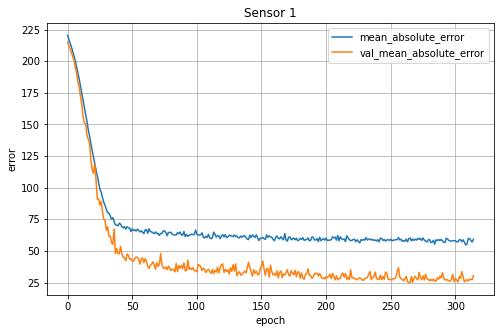

In [91]:
del history1.history["loss"]
del history1.history["val_loss"]
pd.DataFrame(history1.history).plot(figsize=(8,5))
plt.xlabel("epoch")
plt.ylabel('error')
plt.title("Sensor 1")
plt.grid(True)
plt.show

In [169]:
model1.save_weights("model/model1_weights.h5")

## Model 2

In [88]:
defaultConv1D = partial(tf.keras.layers.Conv1D,kernel_size=3,
                                               kernel_initializer=tf.keras.initializers.lecun_normal)
scaler = 9
momentum = 0.99
learning_rate = 0.001

model2 = tf.keras.Sequential()
model2.add(defaultConv1D(filters=2*scaler))
model2.add(tf.keras.layers.BatchNormalization(momentum=momentum))
model2.add(tf.keras.layers.Activation('selu'))
model2.add(tf.keras.layers.MaxPooling1D(pool_size=2))
model2.add(defaultConv1D(filters=3*scaler))
model2.add(tf.keras.layers.BatchNormalization(momentum=momentum))
model2.add(tf.keras.layers.Activation('selu'))
model2.add(tf.keras.layers.MaxPooling1D(pool_size=2))
model2.add(defaultConv1D(filters=4*scaler))
model2.add(tf.keras.layers.BatchNormalization(momentum=momentum))
model2.add(tf.keras.layers.Activation('selu'))
model2.add(tf.keras.layers.MaxPooling1D(pool_size=2))
model2.add(defaultConv1D(filters=5*scaler))
model2.add(tf.keras.layers.BatchNormalization(momentum=momentum))
model2.add(tf.keras.layers.Activation('selu'))
model2.add(tf.keras.layers.MaxPooling1D(pool_size=2))
model2.add(tf.keras.layers.Flatten())
model2.add(tf.keras.layers.Dense(units=50,kernel_initializer=tf.keras.initializers.lecun_normal))
model2.add(tf.keras.layers.BatchNormalization(momentum=momentum))
model2.add(tf.keras.layers.Activation('selu'))
model2.add(tf.keras.layers.Dropout(0.5))
model2.add(tf.keras.layers.Dense(units=2))

model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss='mean_absolute_error',
              metrics=['mean_absolute_error'])

In [89]:
history2 = model2.fit(train_list2,y_train,batch_size=32,epochs=600,
                      validation_split=0.2,callbacks=[early_stopping])

Epoch 1/600
63/63 [==============================] - 3s 22ms/step - loss: 220.8823 - mean_absolute_error: 220.8823 - val_loss: 212.7599 - val_mean_absolute_error: 212.7599
Epoch 2/600
63/63 [==============================] - 1s 15ms/step - loss: 219.0254 - mean_absolute_error: 219.0254 - val_loss: 210.8199 - val_mean_absolute_error: 210.8199
Epoch 3/600
63/63 [==============================] - 1s 16ms/step - loss: 213.9543 - mean_absolute_error: 213.9543 - val_loss: 208.3437 - val_mean_absolute_error: 208.3437
Epoch 4/600
63/63 [==============================] - 1s 16ms/step - loss: 211.2490 - mean_absolute_error: 211.2490 - val_loss: 204.2872 - val_mean_absolute_error: 204.2872
Epoch 5/600
63/63 [==============================] - 1s 16ms/step - loss: 209.1769 - mean_absolute_error: 209.1769 - val_loss: 202.6002 - val_mean_absolute_error: 202.6002
Epoch 6/600
63/63 [==============================] - 1s 16ms/step - loss: 202.5796 - mean_absolute_error: 202.5796 - val_loss: 197.5911 - va

Epoch 49/600
63/63 [==============================] - 1s 19ms/step - loss: 66.8926 - mean_absolute_error: 66.8926 - val_loss: 43.9447 - val_mean_absolute_error: 43.9447
Epoch 50/600
63/63 [==============================] - 1s 20ms/step - loss: 68.2980 - mean_absolute_error: 68.2980 - val_loss: 39.7933 - val_mean_absolute_error: 39.7933
Epoch 51/600
63/63 [==============================] - 1s 19ms/step - loss: 66.7002 - mean_absolute_error: 66.7002 - val_loss: 43.6020 - val_mean_absolute_error: 43.6020
Epoch 52/600
63/63 [==============================] - 1s 20ms/step - loss: 65.4506 - mean_absolute_error: 65.4506 - val_loss: 41.4850 - val_mean_absolute_error: 41.4850
Epoch 53/600
63/63 [==============================] - 1s 21ms/step - loss: 66.5885 - mean_absolute_error: 66.5885 - val_loss: 40.8509 - val_mean_absolute_error: 40.8509
Epoch 54/600
63/63 [==============================] - 1s 21ms/step - loss: 68.4393 - mean_absolute_error: 68.4393 - val_loss: 51.4903 - val_mean_absolute_e

63/63 [==============================] - 3s 47ms/step - loss: 61.8888 - mean_absolute_error: 61.8888 - val_loss: 35.1375 - val_mean_absolute_error: 35.1375
Epoch 98/600
63/63 [==============================] - 3s 49ms/step - loss: 62.0491 - mean_absolute_error: 62.0491 - val_loss: 37.5537 - val_mean_absolute_error: 37.5537
Epoch 99/600
63/63 [==============================] - 3s 48ms/step - loss: 62.2065 - mean_absolute_error: 62.2065 - val_loss: 37.4035 - val_mean_absolute_error: 37.4035
Epoch 100/600
63/63 [==============================] - 3s 50ms/step - loss: 62.5352 - mean_absolute_error: 62.5352 - val_loss: 37.7007 - val_mean_absolute_error: 37.7007
Epoch 101/600
63/63 [==============================] - 3s 49ms/step - loss: 62.5563 - mean_absolute_error: 62.5563 - val_loss: 36.4804 - val_mean_absolute_error: 36.4804
Epoch 102/600
63/63 [==============================] - 3s 50ms/step - loss: 63.9255 - mean_absolute_error: 63.9255 - val_loss: 34.9217 - val_mean_absolute_error: 34.9

63/63 [==============================] - 3s 50ms/step - loss: 59.5349 - mean_absolute_error: 59.5349 - val_loss: 36.0715 - val_mean_absolute_error: 36.0715
Epoch 145/600
63/63 [==============================] - 3s 53ms/step - loss: 57.6962 - mean_absolute_error: 57.6962 - val_loss: 34.2642 - val_mean_absolute_error: 34.2642
Epoch 146/600
63/63 [==============================] - 3s 52ms/step - loss: 60.1351 - mean_absolute_error: 60.1351 - val_loss: 32.5779 - val_mean_absolute_error: 32.5779
Epoch 147/600
63/63 [==============================] - 3s 54ms/step - loss: 61.7398 - mean_absolute_error: 61.7398 - val_loss: 41.4666 - val_mean_absolute_error: 41.4666
Epoch 148/600
63/63 [==============================] - 3s 50ms/step - loss: 62.1958 - mean_absolute_error: 62.1958 - val_loss: 49.0247 - val_mean_absolute_error: 49.0247
Epoch 149/600
63/63 [==============================] - 3s 51ms/step - loss: 62.0864 - mean_absolute_error: 62.0864 - val_loss: 31.9069 - val_mean_absolute_error: 31

63/63 [==============================] - 3s 51ms/step - loss: 60.1138 - mean_absolute_error: 60.1138 - val_loss: 34.1148 - val_mean_absolute_error: 34.1148
Epoch 193/600
63/63 [==============================] - 3s 49ms/step - loss: 56.3790 - mean_absolute_error: 56.3790 - val_loss: 31.2752 - val_mean_absolute_error: 31.2752
Epoch 194/600
63/63 [==============================] - 3s 51ms/step - loss: 61.0276 - mean_absolute_error: 61.0276 - val_loss: 29.7338 - val_mean_absolute_error: 29.7338
Epoch 195/600
63/63 [==============================] - 3s 50ms/step - loss: 56.9199 - mean_absolute_error: 56.9199 - val_loss: 31.4874 - val_mean_absolute_error: 31.4874
Epoch 196/600
63/63 [==============================] - 3s 52ms/step - loss: 57.9224 - mean_absolute_error: 57.9224 - val_loss: 32.5513 - val_mean_absolute_error: 32.5513
Epoch 197/600
63/63 [==============================] - 3s 51ms/step - loss: 58.4257 - mean_absolute_error: 58.4257 - val_loss: 31.8115 - val_mean_absolute_error: 31

63/63 [==============================] - 3s 52ms/step - loss: 55.0976 - mean_absolute_error: 55.0976 - val_loss: 28.6543 - val_mean_absolute_error: 28.6543
Epoch 241/600
63/63 [==============================] - 3s 52ms/step - loss: 60.4686 - mean_absolute_error: 60.4686 - val_loss: 27.5630 - val_mean_absolute_error: 27.5630
Epoch 242/600
63/63 [==============================] - 3s 50ms/step - loss: 58.0791 - mean_absolute_error: 58.0791 - val_loss: 27.6006 - val_mean_absolute_error: 27.6006
Epoch 243/600
63/63 [==============================] - 3s 52ms/step - loss: 58.5402 - mean_absolute_error: 58.5402 - val_loss: 31.1048 - val_mean_absolute_error: 31.1048
Epoch 244/600
63/63 [==============================] - 3s 50ms/step - loss: 56.8581 - mean_absolute_error: 56.8581 - val_loss: 26.7364 - val_mean_absolute_error: 26.7364
Epoch 245/600
63/63 [==============================] - 4s 56ms/step - loss: 56.5822 - mean_absolute_error: 56.5822 - val_loss: 30.9247 - val_mean_absolute_error: 30

63/63 [==============================] - 4s 57ms/step - loss: 56.7652 - mean_absolute_error: 56.7652 - val_loss: 26.9716 - val_mean_absolute_error: 26.9716
Epoch 288/600
63/63 [==============================] - 4s 57ms/step - loss: 56.3137 - mean_absolute_error: 56.3137 - val_loss: 29.0726 - val_mean_absolute_error: 29.0726
Epoch 289/600
63/63 [==============================] - 4s 58ms/step - loss: 59.6868 - mean_absolute_error: 59.6868 - val_loss: 28.5957 - val_mean_absolute_error: 28.5957
Epoch 290/600
63/63 [==============================] - 3s 55ms/step - loss: 56.1868 - mean_absolute_error: 56.1868 - val_loss: 31.0786 - val_mean_absolute_error: 31.0786
Epoch 291/600
63/63 [==============================] - 4s 63ms/step - loss: 56.4947 - mean_absolute_error: 56.4947 - val_loss: 26.7967 - val_mean_absolute_error: 26.7967
Epoch 292/600
63/63 [==============================] - 3s 55ms/step - loss: 59.7804 - mean_absolute_error: 59.7804 - val_loss: 34.0913 - val_mean_absolute_error: 34

<function matplotlib.pyplot.show(close=None, block=None)>

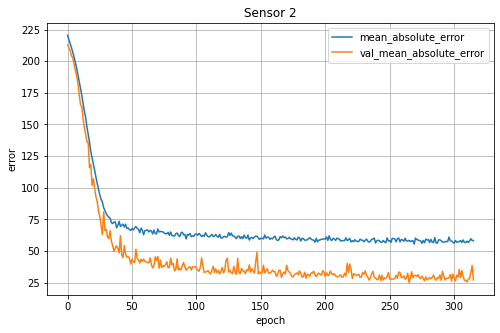

In [92]:
del history2.history["loss"]
del history2.history["val_loss"]
pd.DataFrame(history2.history).plot(figsize=(8,5))
plt.xlabel("epoch")
plt.ylabel('error')
plt.title("Sensor 2")
plt.grid(True)
plt.show

In [170]:
model2.save_weights("model/model2_weights.h5")

## Model 3

In [93]:
defaultConv1D = partial(tf.keras.layers.Conv1D,kernel_size=3,
                                               kernel_initializer=tf.keras.initializers.lecun_normal)
scaler = 9
momentum = 0.99
learning_rate = 0.001

model3 = tf.keras.Sequential()
model3.add(defaultConv1D(filters=2*scaler))
model3.add(tf.keras.layers.BatchNormalization(momentum=momentum))
model3.add(tf.keras.layers.Activation('selu'))
model3.add(tf.keras.layers.MaxPooling1D(pool_size=2))
model3.add(defaultConv1D(filters=3*scaler))
model3.add(tf.keras.layers.BatchNormalization(momentum=momentum))
model3.add(tf.keras.layers.Activation('selu'))
model3.add(tf.keras.layers.MaxPooling1D(pool_size=2))
model3.add(defaultConv1D(filters=4*scaler))
model3.add(tf.keras.layers.BatchNormalization(momentum=momentum))
model3.add(tf.keras.layers.Activation('selu'))
model3.add(tf.keras.layers.MaxPooling1D(pool_size=2))
model3.add(defaultConv1D(filters=5*scaler))
model3.add(tf.keras.layers.BatchNormalization(momentum=momentum))
model3.add(tf.keras.layers.Activation('selu'))
model3.add(tf.keras.layers.MaxPooling1D(pool_size=2))
model3.add(tf.keras.layers.Flatten())
model3.add(tf.keras.layers.Dense(units=50,kernel_initializer=tf.keras.initializers.lecun_normal))
model3.add(tf.keras.layers.BatchNormalization(momentum=momentum))
model3.add(tf.keras.layers.Activation('selu'))
model3.add(tf.keras.layers.Dropout(0.5))
model3.add(tf.keras.layers.Dense(units=2))

model3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss='mean_absolute_error',
              metrics=['mean_absolute_error'])

In [94]:
history3 = model3.fit(train_list3,y_train,batch_size=32,epochs=600,
                      validation_split=0.2,callbacks=[early_stopping])

Epoch 1/600
63/63 [==============================] - 18s 52ms/step - loss: 223.0910 - mean_absolute_error: 223.0910 - val_loss: 215.5910 - val_mean_absolute_error: 215.5910
Epoch 2/600
63/63 [==============================] - 1s 21ms/step - loss: 214.4765 - mean_absolute_error: 214.4765 - val_loss: 214.7197 - val_mean_absolute_error: 214.7197
Epoch 3/600
63/63 [==============================] - 1s 21ms/step - loss: 216.0635 - mean_absolute_error: 216.0635 - val_loss: 211.0653 - val_mean_absolute_error: 211.0653
Epoch 4/600
63/63 [==============================] - 1s 19ms/step - loss: 213.6050 - mean_absolute_error: 213.6050 - val_loss: 207.5883 - val_mean_absolute_error: 207.5883
Epoch 5/600
63/63 [==============================] - 1s 20ms/step - loss: 208.4755 - mean_absolute_error: 208.4755 - val_loss: 200.1678 - val_mean_absolute_error: 200.1678
Epoch 6/600
63/63 [==============================] - 1s 20ms/step - loss: 206.0366 - mean_absolute_error: 206.0366 - val_loss: 201.1295 - v

63/63 [==============================] - 1s 18ms/step - loss: 137.3961 - mean_absolute_error: 137.3961 - val_loss: 126.1336 - val_mean_absolute_error: 126.1336
Epoch 49/600
63/63 [==============================] - 1s 19ms/step - loss: 134.9700 - mean_absolute_error: 134.9700 - val_loss: 126.7535 - val_mean_absolute_error: 126.7535
Epoch 50/600
63/63 [==============================] - 1s 18ms/step - loss: 137.3495 - mean_absolute_error: 137.3495 - val_loss: 131.1785 - val_mean_absolute_error: 131.1785
Epoch 51/600
63/63 [==============================] - 1s 18ms/step - loss: 133.0231 - mean_absolute_error: 133.0231 - val_loss: 126.7726 - val_mean_absolute_error: 126.7726
Epoch 52/600
63/63 [==============================] - 1s 19ms/step - loss: 133.8029 - mean_absolute_error: 133.8029 - val_loss: 124.0805 - val_mean_absolute_error: 124.0805
Epoch 53/600
63/63 [==============================] - 1s 18ms/step - loss: 134.3024 - mean_absolute_error: 134.3024 - val_loss: 141.8673 - val_mean_

63/63 [==============================] - 1s 18ms/step - loss: 137.8086 - mean_absolute_error: 137.8086 - val_loss: 125.1592 - val_mean_absolute_error: 125.1592
Epoch 96/600
63/63 [==============================] - 1s 19ms/step - loss: 135.9739 - mean_absolute_error: 135.9739 - val_loss: 127.9408 - val_mean_absolute_error: 127.9408
Epoch 97/600
63/63 [==============================] - 1s 18ms/step - loss: 135.6594 - mean_absolute_error: 135.6594 - val_loss: 123.5300 - val_mean_absolute_error: 123.5300
Epoch 98/600
63/63 [==============================] - 1s 19ms/step - loss: 134.9541 - mean_absolute_error: 134.9541 - val_loss: 122.8092 - val_mean_absolute_error: 122.8092
Epoch 99/600
63/63 [==============================] - 1s 18ms/step - loss: 132.6873 - mean_absolute_error: 132.6873 - val_loss: 121.4599 - val_mean_absolute_error: 121.4599
Epoch 100/600
63/63 [==============================] - 1s 18ms/step - loss: 132.8425 - mean_absolute_error: 132.8425 - val_loss: 127.4272 - val_mean

63/63 [==============================] - 1s 19ms/step - loss: 133.2014 - mean_absolute_error: 133.2014 - val_loss: 121.4629 - val_mean_absolute_error: 121.4629
Epoch 143/600
63/63 [==============================] - 1s 20ms/step - loss: 137.6790 - mean_absolute_error: 137.6790 - val_loss: 136.8856 - val_mean_absolute_error: 136.8856
Epoch 144/600
63/63 [==============================] - 1s 19ms/step - loss: 132.4426 - mean_absolute_error: 132.4426 - val_loss: 127.7408 - val_mean_absolute_error: 127.7408
Epoch 145/600
63/63 [==============================] - 1s 19ms/step - loss: 134.1248 - mean_absolute_error: 134.1248 - val_loss: 123.0663 - val_mean_absolute_error: 123.0663
Epoch 146/600
63/63 [==============================] - 1s 18ms/step - loss: 133.0577 - mean_absolute_error: 133.0577 - val_loss: 124.4879 - val_mean_absolute_error: 124.4879
Epoch 147/600
63/63 [==============================] - 1s 18ms/step - loss: 134.7034 - mean_absolute_error: 134.7034 - val_loss: 124.3631 - val_

63/63 [==============================] - 1s 18ms/step - loss: 135.5384 - mean_absolute_error: 135.5384 - val_loss: 123.9372 - val_mean_absolute_error: 123.9372
Epoch 190/600
63/63 [==============================] - 1s 19ms/step - loss: 133.9427 - mean_absolute_error: 133.9427 - val_loss: 125.2374 - val_mean_absolute_error: 125.2374
Epoch 191/600
63/63 [==============================] - 1s 20ms/step - loss: 139.8061 - mean_absolute_error: 139.8061 - val_loss: 127.5141 - val_mean_absolute_error: 127.5141
Epoch 192/600
63/63 [==============================] - 1s 19ms/step - loss: 134.0819 - mean_absolute_error: 134.0819 - val_loss: 122.8676 - val_mean_absolute_error: 122.8676
Epoch 193/600
63/63 [==============================] - 1s 19ms/step - loss: 136.6353 - mean_absolute_error: 136.6353 - val_loss: 122.2355 - val_mean_absolute_error: 122.2355
Epoch 194/600
63/63 [==============================] - 1s 19ms/step - loss: 137.8671 - mean_absolute_error: 137.8671 - val_loss: 123.1353 - val_

63/63 [==============================] - 1s 20ms/step - loss: 135.2798 - mean_absolute_error: 135.2798 - val_loss: 124.1517 - val_mean_absolute_error: 124.1517
Epoch 237/600
63/63 [==============================] - 1s 18ms/step - loss: 134.3640 - mean_absolute_error: 134.3640 - val_loss: 123.4896 - val_mean_absolute_error: 123.4896
Epoch 238/600
63/63 [==============================] - 1s 18ms/step - loss: 136.3293 - mean_absolute_error: 136.3293 - val_loss: 121.7192 - val_mean_absolute_error: 121.7192
Epoch 239/600
63/63 [==============================] - 1s 19ms/step - loss: 135.3062 - mean_absolute_error: 135.3062 - val_loss: 120.8034 - val_mean_absolute_error: 120.8034
Epoch 240/600
63/63 [==============================] - 1s 18ms/step - loss: 135.8916 - mean_absolute_error: 135.8916 - val_loss: 127.0055 - val_mean_absolute_error: 127.0055
Epoch 241/600
63/63 [==============================] - 1s 19ms/step - loss: 135.6629 - mean_absolute_error: 135.6629 - val_loss: 123.5662 - val_

63/63 [==============================] - 1s 20ms/step - loss: 136.3277 - mean_absolute_error: 136.3277 - val_loss: 131.2159 - val_mean_absolute_error: 131.2159
Epoch 284/600
63/63 [==============================] - 1s 20ms/step - loss: 132.8237 - mean_absolute_error: 132.8237 - val_loss: 129.8670 - val_mean_absolute_error: 129.8670
Epoch 285/600
63/63 [==============================] - 1s 23ms/step - loss: 137.1005 - mean_absolute_error: 137.1005 - val_loss: 122.6297 - val_mean_absolute_error: 122.6297
Epoch 286/600
63/63 [==============================] - 1s 22ms/step - loss: 133.1042 - mean_absolute_error: 133.1042 - val_loss: 125.5808 - val_mean_absolute_error: 125.5808
Epoch 287/600
63/63 [==============================] - 1s 20ms/step - loss: 135.6020 - mean_absolute_error: 135.6020 - val_loss: 121.0357 - val_mean_absolute_error: 121.0357
Epoch 288/600
63/63 [==============================] - 1s 20ms/step - loss: 137.0389 - mean_absolute_error: 137.0389 - val_loss: 127.8196 - val_

Epoch 330/600
63/63 [==============================] - 1s 20ms/step - loss: 131.7010 - mean_absolute_error: 131.7010 - val_loss: 123.4508 - val_mean_absolute_error: 123.4508
Epoch 331/600
63/63 [==============================] - 1s 20ms/step - loss: 136.2976 - mean_absolute_error: 136.2976 - val_loss: 121.9622 - val_mean_absolute_error: 121.9622
Epoch 332/600
63/63 [==============================] - 1s 20ms/step - loss: 134.1000 - mean_absolute_error: 134.1000 - val_loss: 120.1820 - val_mean_absolute_error: 120.1820
Epoch 333/600
63/63 [==============================] - 1s 20ms/step - loss: 137.9128 - mean_absolute_error: 137.9128 - val_loss: 121.9390 - val_mean_absolute_error: 121.9390
Epoch 334/600
63/63 [==============================] - 1s 20ms/step - loss: 137.5217 - mean_absolute_error: 137.5217 - val_loss: 121.8742 - val_mean_absolute_error: 121.8742
Epoch 335/600
63/63 [==============================] - 1s 20ms/step - loss: 132.4998 - mean_absolute_error: 132.4998 - val_loss: 1

63/63 [==============================] - 1s 20ms/step - loss: 130.8104 - mean_absolute_error: 130.8104 - val_loss: 123.6927 - val_mean_absolute_error: 123.6927


<function matplotlib.pyplot.show(close=None, block=None)>

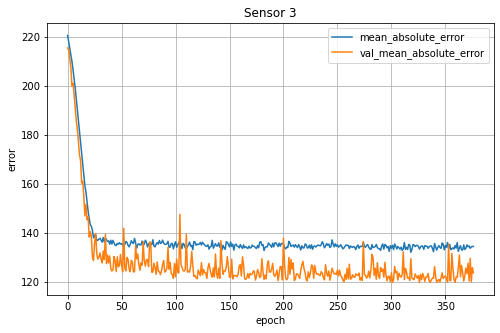

In [95]:
del history3.history["loss"]
del history3.history["val_loss"]
pd.DataFrame(history3.history).plot(figsize=(8,5))
plt.xlabel("epoch")
plt.ylabel('error')
plt.title("Sensor 3")
plt.grid(True)
plt.show

In [171]:
model3.save_weights("model/model3_weights.h5")

##  Model 4

In [98]:
defaultConv1D = partial(tf.keras.layers.Conv1D,kernel_size=3,
                                               kernel_initializer=tf.keras.initializers.lecun_normal)
scaler = 9
momentum = 0.99
learning_rate = 0.001

model4 = tf.keras.Sequential()
model4.add(defaultConv1D(filters=2*scaler))
model4.add(tf.keras.layers.BatchNormalization(momentum=momentum))
model4.add(tf.keras.layers.Activation('selu'))
model4.add(tf.keras.layers.MaxPooling1D(pool_size=2))
model4.add(defaultConv1D(filters=3*scaler))
model4.add(tf.keras.layers.BatchNormalization(momentum=momentum))
model4.add(tf.keras.layers.Activation('selu'))
model4.add(tf.keras.layers.MaxPooling1D(pool_size=2))
model4.add(defaultConv1D(filters=4*scaler))
model4.add(tf.keras.layers.BatchNormalization(momentum=momentum))
model4.add(tf.keras.layers.Activation('selu'))
model4.add(tf.keras.layers.MaxPooling1D(pool_size=2))
model4.add(defaultConv1D(filters=5*scaler))
model4.add(tf.keras.layers.BatchNormalization(momentum=momentum))
model4.add(tf.keras.layers.Activation('selu'))
model4.add(tf.keras.layers.MaxPooling1D(pool_size=2))
model4.add(tf.keras.layers.Flatten())
model4.add(tf.keras.layers.Dense(units=50,kernel_initializer=tf.keras.initializers.lecun_normal))
model4.add(tf.keras.layers.BatchNormalization(momentum=momentum))
model4.add(tf.keras.layers.Activation('selu'))
model4.add(tf.keras.layers.Dropout(0.5))
model4.add(tf.keras.layers.Dense(units=4))

model4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss='mean_absolute_error',
              metrics=['mean_absolute_error'])

In [138]:
history4 = model4.fit(train_list4,y_train,batch_size=16,epochs=25,
                      validation_split=0.2,callbacks=[early_stopping])

Epoch 1/25
126/126 [==============================] - 3s 13ms/step - loss: 131.6312 - mean_absolute_error: 131.6312 - val_loss: 100.7418 - val_mean_absolute_error: 100.7418
Epoch 2/25
126/126 [==============================] - 1s 11ms/step - loss: 91.1991 - mean_absolute_error: 91.1991 - val_loss: 89.1666 - val_mean_absolute_error: 89.1666
Epoch 3/25
126/126 [==============================] - 1s 11ms/step - loss: 84.6532 - mean_absolute_error: 84.6532 - val_loss: 77.0880 - val_mean_absolute_error: 77.0880
Epoch 4/25
126/126 [==============================] - 1s 11ms/step - loss: 80.7149 - mean_absolute_error: 80.7149 - val_loss: 72.5469 - val_mean_absolute_error: 72.5469
Epoch 5/25
126/126 [==============================] - 1s 11ms/step - loss: 82.2561 - mean_absolute_error: 82.2561 - val_loss: 66.7358 - val_mean_absolute_error: 66.7358
Epoch 6/25
126/126 [==============================] - 1s 11ms/step - loss: 80.4759 - mean_absolute_error: 80.4759 - val_loss: 68.2567 - val_mean_absolu

<function matplotlib.pyplot.show(close=None, block=None)>

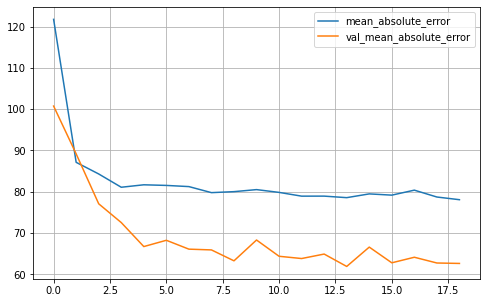

In [139]:
del history4.history["loss"]
del history4.history["val_loss"]
pd.DataFrame(history4.history).plot(figsize=(8,5))
plt.grid(True)
plt.show

In [172]:
model4.save_weights("model/model4_weights.h5")

# Global Fine Tuning

In [97]:
momentum = 0.99
learning_rate = 0.001
conc_list = list()
input_list = list()
for i in range(4):
    model = vars()[f'model{i+1}']
    model = Model(inputs=model.input,outputs=model.layers[-6].output)
    input_list.append(model.input)
    conc_list.append(model.output)
concatenate = Concatenate()(conc_list)
dense = tf.keras.layers.Dense(units=200,kernel_initializer=tf.keras.initializers.lecun_normal)(concatenate)
batchnorm = tf.keras.layers.BatchNormalization(momentum=momentum)(dense)
activation = tf.keras.layers.Activation('selu')(batchnorm)
dropout = tf.keras.layers.Dropout(0.5)(activation)
output = tf.keras.layers.Dense(units=4)(dropout)

final_model = Model(inputs=input_list,outputs=output)
final_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                    loss='mean_absolute_error',
                    metrics=['mean_absolute_error'])

AttributeError: 'Sequential' object has no attribute '_nested_inputs'

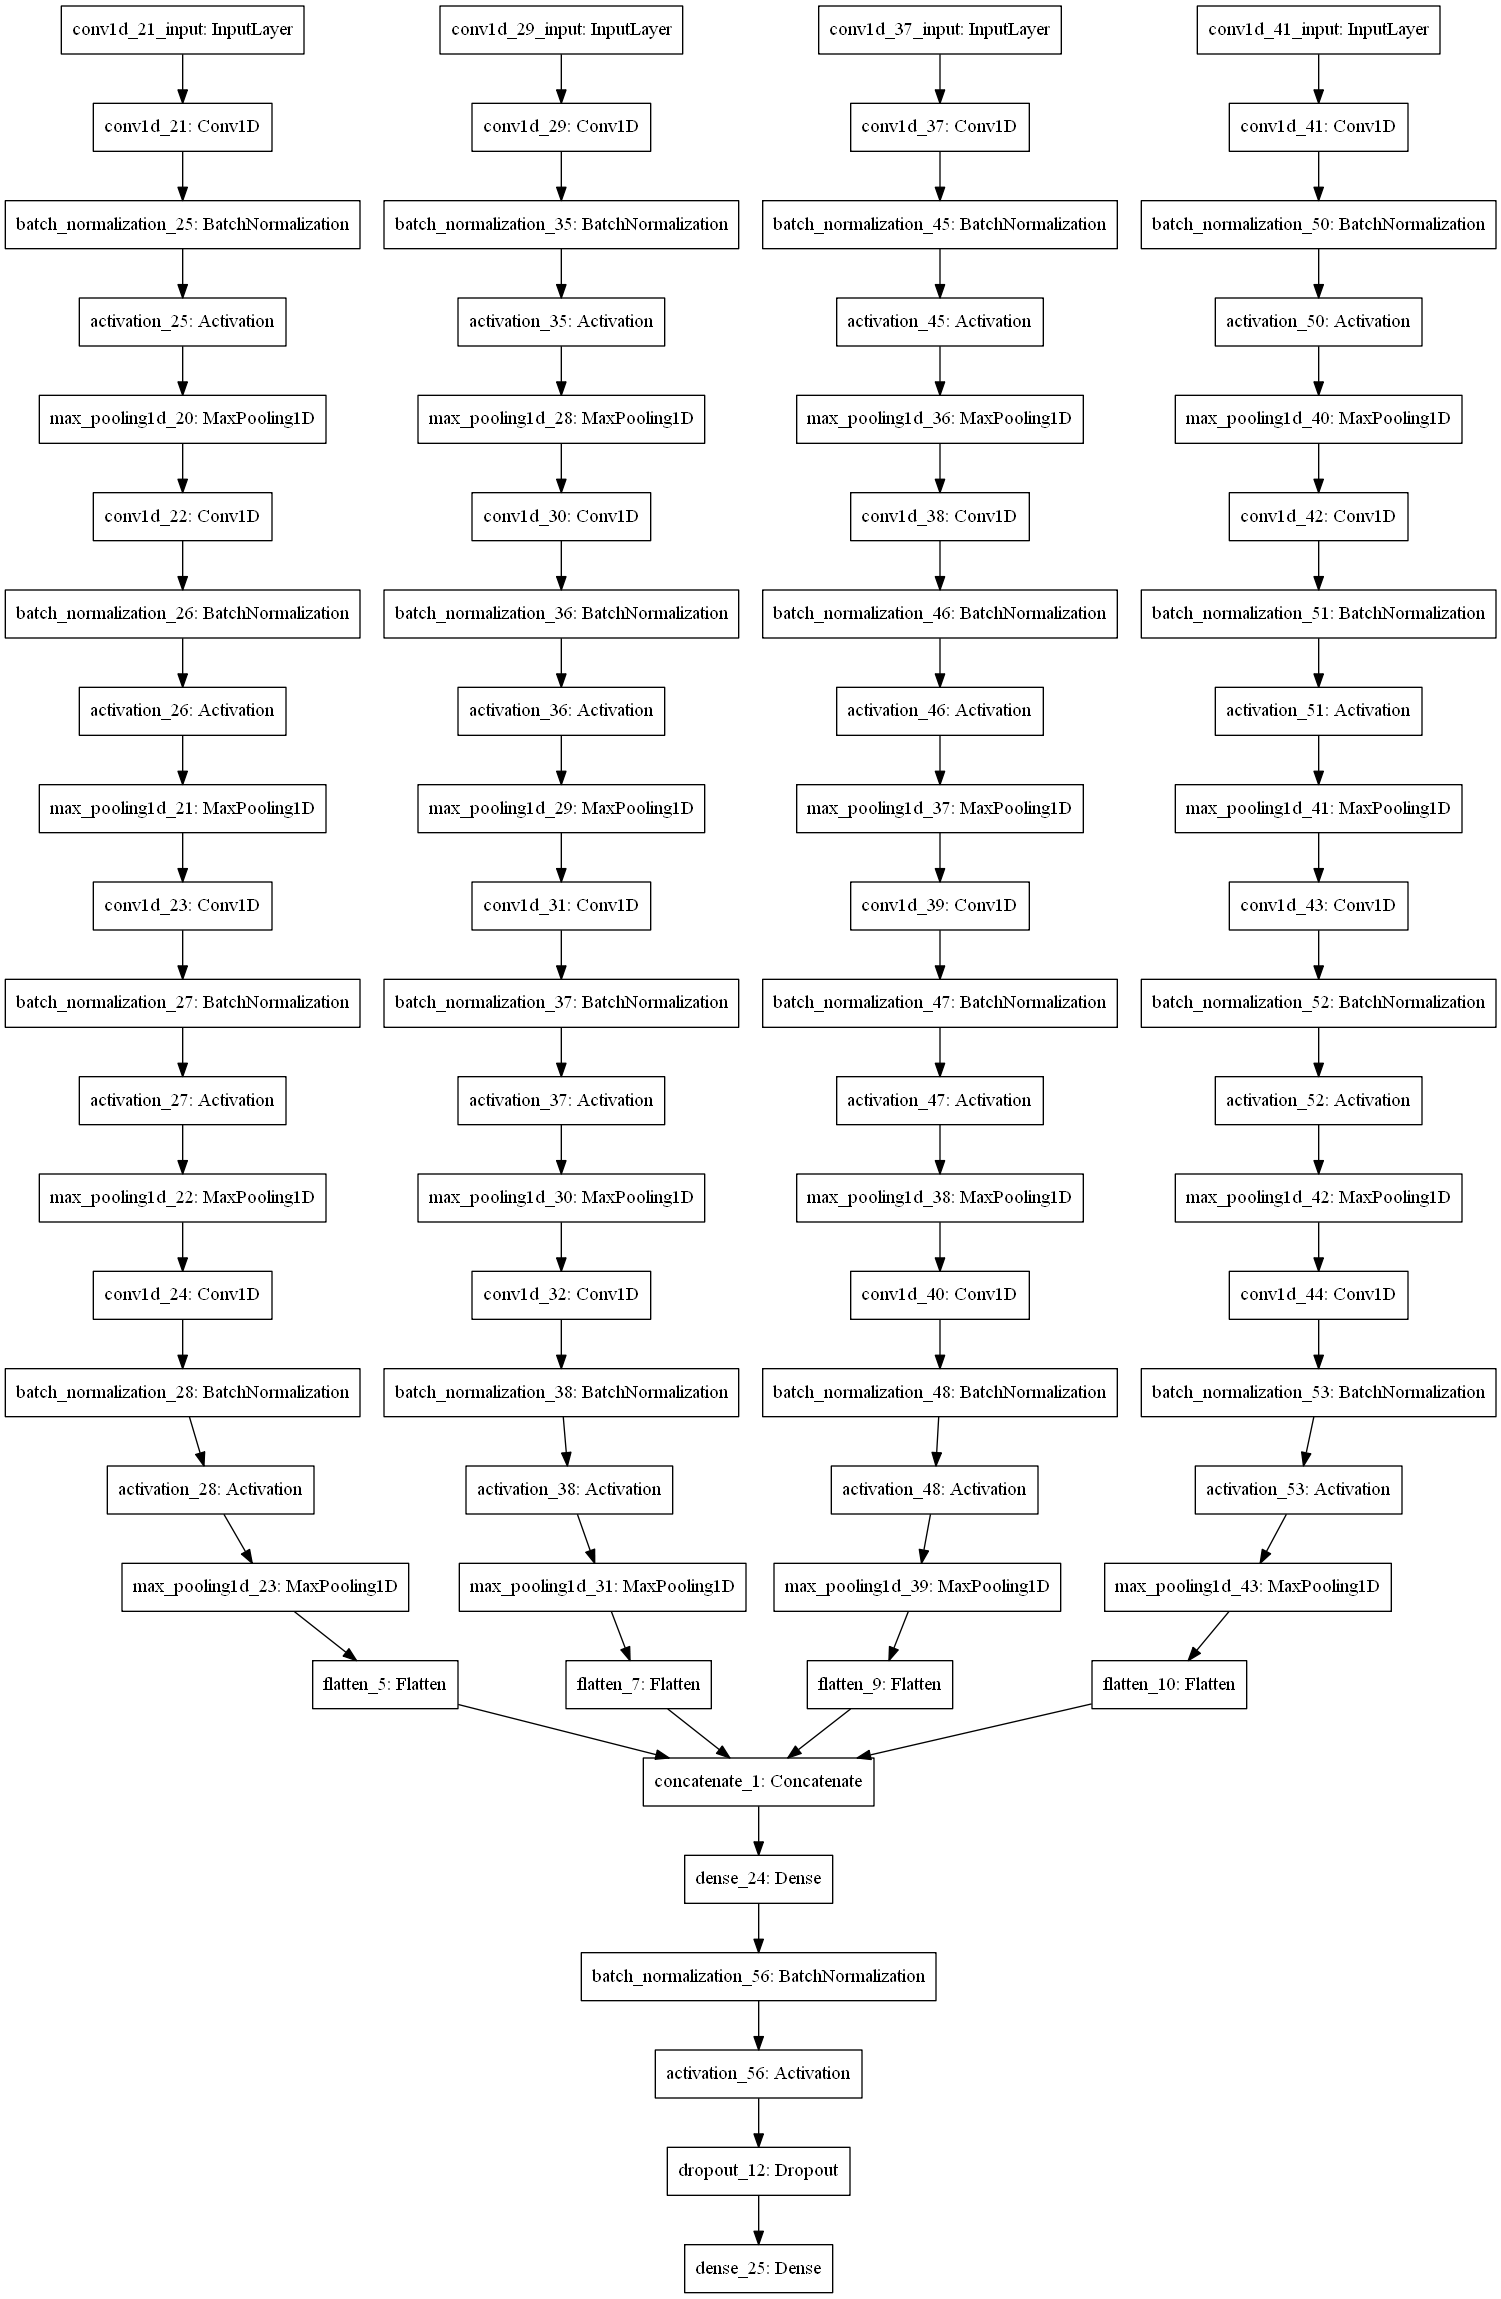

In [161]:
plot_model(final_model)

In [162]:
history_final = final_model.fit(train_fit,y_train,validation_split=0.2,batch_size=16,epochs=25,
                callbacks=[early_stopping])

Epoch 1/25
126/126 [==============================] - 8s 29ms/step - loss: 110.3822 - mean_absolute_error: 110.3822 - val_loss: 98.8945 - val_mean_absolute_error: 98.8945
Epoch 2/25
126/126 [==============================] - 3s 24ms/step - loss: 36.9806 - mean_absolute_error: 36.9806 - val_loss: 53.6363 - val_mean_absolute_error: 53.6363
Epoch 3/25
126/126 [==============================] - 3s 24ms/step - loss: 35.7194 - mean_absolute_error: 35.7194 - val_loss: 21.1921 - val_mean_absolute_error: 21.1921
Epoch 4/25
126/126 [==============================] - 3s 24ms/step - loss: 36.3900 - mean_absolute_error: 36.3900 - val_loss: 15.2337 - val_mean_absolute_error: 15.2337
Epoch 5/25
126/126 [==============================] - 3s 26ms/step - loss: 33.6721 - mean_absolute_error: 33.6721 - val_loss: 31.9723 - val_mean_absolute_error: 31.9723
Epoch 6/25
126/126 [==============================] - 4s 29ms/step - loss: 36.4553 - mean_absolute_error: 36.4553 - val_loss: 39.8040 - val_mean_absolute

<function matplotlib.pyplot.show(close=None, block=None)>

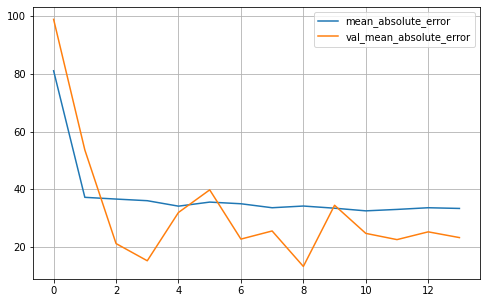

In [163]:
del history_final.history["loss"]
del history_final.history["val_loss"]
pd.DataFrame(history_final.history).plot(figsize=(8,5))
plt.grid(True)
plt.show

In [173]:
final_model.save_weights("model/final_model_weights.h5")

In [218]:
final_model.evaluate(test_fit,y_test)

9/9 [==============================] - 0s 9ms/step - loss: 108.5471 - mean_absolute_error: 108.5471


[108.54711151123047, 108.54711151123047]

In [219]:
final_model.predict(test_fit[0])

ValueError: in user code:

    D:\anaconda\lib\site-packages\tensorflow\python\keras\engine\training.py:1478 predict_function  *
        return step_function(self, iterator)
    D:\anaconda\lib\site-packages\tensorflow\python\keras\engine\training.py:1468 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    D:\anaconda\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    D:\anaconda\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    D:\anaconda\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    D:\anaconda\lib\site-packages\tensorflow\python\keras\engine\training.py:1461 run_step  **
        outputs = model.predict_step(data)
    D:\anaconda\lib\site-packages\tensorflow\python\keras\engine\training.py:1434 predict_step
        return self(x, training=False)
    D:\anaconda\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    D:\anaconda\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:204 assert_input_compatibility
        raise ValueError('Layer ' + layer_name + ' expects ' +

    ValueError: Layer model_9 expects 4 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 375) dtype=float32>]


In [224]:
test_fit[0][0].shape

(375,)

In [226]:
test_fit[0].shape

(280, 375)

In [232]:
train_fit[0].shape

(2520, 375)